In [1]:
# mnist_softmax_deep_relu
# 4 layers

# MNIST(Modified National Institute of Standard Technology) Dataset
# https://ko.wikipedia.org/wiki/MNIST
# label : 0 ~ 9 , 손글씨체 이미지  28*28(784 byte) , gray scale
# Train : 60000개 , Test : 10000개

# mini batch : 큰 데이터를 쪼개어 1회에 작은 단위로 가져다가 학습, next_batch()
# epoch : batch를 반복하여 전체 데이터가 모두 소진되었을 때를 1 epoch
# Vanishing Gradient  : 신경망이 깊어 질수록 입력신호가 사라진다(줄어든다), sigmoid 사용시
# Relu  : Rectified Linear Unit, DNN(deep neural net) 구현시 sigmoid 대신 사용됨
# dropout : 전체 신경망의 일부를 사용하지 않고 학습, 예측시는 전체를 사용

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(5)

In [2]:
# mnist 데이터 가져오기
# mnist = tf.keras.datasets.fashion-mnist
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000,)
<class 'numpy.ndarray'> (10000, 28, 28)
<class 'numpy.ndarray'> (10000,)
5


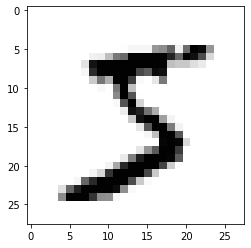

In [3]:
# 이미지로 출력
def show_one_image(n):
    print(type(x_train),x_train.shape) # (60000, 28, 28)
    print(type(y_train),y_train.shape) # (60000,)
    print(type(x_test),x_test.shape)   # (10000, 28, 28)
    print(type(y_test),y_test.shape)   # (10000,)
    
    image = x_train[n]
    print(y_train[n])
    
    plt.imshow(image,cmap='Greys')
    plt.show()

show_one_image(0)

In [4]:
# x값의 shape을 2차원으로 변환
x_train = x_train.reshape(-1,28*28) # -1은 자동으로 6만으로 채워짐
x_test = x_test.reshape(-1,28*28) 

# x값의 타입을 float형으로 변환
# tf.cast() (numpy array가 텐서객체로 바뀜)
x_train = tf.cast(x_train,dtype=tf.float32)
x_test = tf.cast(x_test,dtype=tf.float32)

print(x_train.shape,x_train.dtype)
print(x_test.shape)

(60000, 784) <dtype: 'float32'>
(10000, 784)


In [5]:
# one-hot 인코딩
# 0 : [1 0 0 0 0 0 0]
# 1 : [0 1 0 0 0 0 0]
# ...
# 6 : [0 0 0 0 0 0 1]

nb_classes = 10 # class 범주 갯수 (0~9)

Y_one_hot = tf.one_hot(y_train, nb_classes)
print(Y_one_hot.shape) # (60000,10), Rank=2 (2차원)

(60000, 10)


In [6]:
# Layer 1 : W1 (_,512)
# Layer 2 : W2 (_,512)
# Layer 3 : W3 (_,512)
# Layer 4 : W (_,_)

In [7]:
# Layer  1
# (60000,784) * (784,512) = (60000,512)
W1 = tf.Variable(tf.random.normal([784,512]), name='weight1')
b1 = tf.Variable(tf.random.normal([512]), name='bias1')

def layer1(X):
    return  tf.nn.relu(tf.matmul(X,W1) + b1 )

# layer 2
# (60000,512) * (512,512) = (60000,512)
W2 = tf.Variable(tf.random.normal([512,512]), name='weight2')
b2 = tf.Variable(tf.random.normal([512]), name='bias2')

def layer2(X):
    return  tf.nn.relu(tf.matmul(layer1(X),W2) + b2 )

# layer 3
# (60000,512) * (512,512) = (60000,512)
W3 = tf.Variable(tf.random.normal([512,512]), name='weight3')
b3 = tf.Variable(tf.random.normal([512]), name='bias3')

def layer3(X):
    return  tf.nn.relu(tf.matmul(layer2(X),W3) + b3 )


In [8]:
# 변수 초기화 : weight, bias
#   X   *   W   = Y
# (m,n) * (n,l) = (m,l)   : 행렬의 내적 곱셈 공식
# (60000,512) * (512,10) = (60000,10)
W4 = tf.Variable(tf.random.normal([512,nb_classes]),name='weight4')
b4 = tf.Variable(tf.random.normal([nb_classes]),name='bias4')

# 예측 함수(hypothesis) : H(X) = softmax(X*W + B)
def logits(X):
    return tf.matmul(layer3(X),W4) + b4

def hypothesis(X):
    return tf.nn.softmax(logits(X))  

In [9]:
#  비용함수 구현 방법 2 : tf.nn.softmax_cross_entropy_with_logits() 함수 사용
def cost_func():
    cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits(x_train),
                                                    labels=Y_one_hot)
    cost = tf.reduce_mean(cost_i)
    return cost

In [10]:
# 경사 하강법
# learning_rate(학습율)을 0.01 로 설정하여 optimizer객체를 생성
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [11]:
# 방법 1. 전체 데이터를 한번에 학습, 비효율적이며 학습에 장시간 소요
# 학습 시작
# print('***** Start Learning!!')
# for step in range(2001):
#     optimizer.minimize(cost_func,var_list=[W,b])
#     if step % 1000 == 0:
#         print('%04d'%step,'cost:[',cost_func().numpy(),']')
            
# print('***** Learning Finished!!') 

In [12]:
# 방법 2. batch 사이즈로 나누어 학습, 효율적 이며 학습 시간 단축
# 학습 시작

training_epoch = 25
batch_size = 600

print('***** Start Learning!!')
for epoch in range(training_epoch):  # 25회
    
    avg_cost = 0
    
    # 100 = 60000/600
    total_batch = int(x_train.shape[0]/batch_size)
    for k in range(total_batch):  # 100회
        batch_xs = x_train[0 + k*batch_size:batch_size + k*batch_size]   # 600개의 X 데이터
        batch_ys = Y_one_hot[0 + k*batch_size:batch_size + k*batch_size] # 600개의 Y 데이터
        
        # 비용함수
        def cost_func_batch():
            cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits(batch_xs),
                                                            labels=batch_ys)
            cost = tf.reduce_mean(cost_i)
            return cost
        
        optimizer.minimize(cost_func_batch,var_list=[W1,W2,W3,W4,b1,b2,b3,b4])
        avg_cost += cost_func_batch().numpy()/total_batch
        
    print('Epoch:','%04d'%(epoch + 1),'cost:','{:.9f}'.format(avg_cost))
print('***** Learning Finish!!')
    

***** Start Learning!!
Epoch: 0001 cost: 915109.186992187
Epoch: 0002 cost: 83774.787812500
Epoch: 0003 cost: 36611.189218750
Epoch: 0004 cost: 17804.676250000
Epoch: 0005 cost: 8753.346788330
Epoch: 0006 cost: 4863.078907166
Epoch: 0007 cost: 3709.806672058
Epoch: 0008 cost: 2892.177485504
Epoch: 0009 cost: 1632.921655712
Epoch: 0010 cost: 1020.086128695
Epoch: 0011 cost: 641.581643353
Epoch: 0012 cost: 646.981435562
Epoch: 0013 cost: 561.247638817
Epoch: 0014 cost: 279.327232285
Epoch: 0015 cost: 480.620170889
Epoch: 0016 cost: 512.202260485
Epoch: 0017 cost: 562.213053692
Epoch: 0018 cost: 440.208343649
Epoch: 0019 cost: 521.726006932
Epoch: 0020 cost: 880.448419418
Epoch: 0021 cost: 861.431373343
Epoch: 0022 cost: 725.149771013
Epoch: 0023 cost: 922.627903557
Epoch: 0024 cost: 750.665122504
Epoch: 0025 cost: 1114.363906822
***** Learning Finish!!


In [13]:
# 정확도 측정(평가)

# y_test값을 one-hot인코딩
Y_one_hot = tf.one_hot(y_test,nb_classes)  
print(Y_one_hot.shape)                     # (31,1,7), Rank=3 (3차원)

def predict(X):
    return tf.argmax(hypothesis(X),axis=1)

correct_predict = tf.equal(predict(x_test),tf.argmax(Y_one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_predict,dtype=tf.float32))
print('Accuracy:',accuracy.numpy())  # Accuracy: 0.8064516

(10000, 10)
Accuracy: 0.9658


In [14]:
# 예측
print('***** Predict')
pred = predict(x_test).numpy()
print(pred,y_test)

***** Predict
[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


random =  9752 Label: 2
Prediction :  [2]


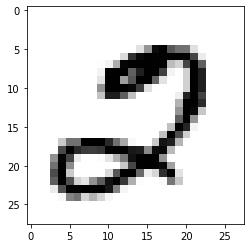

In [15]:
# 임의의 test 데이터로 예측한 값 시각화하기
r = np.random.randint(0,x_test.shape[0] - 1) # 0 to 9999 random int number
# r = 1411   # Label: 0, Prediction :  [9]

print('random = ',r, 'Label:',y_test[r])

print('Prediction : ',predict(x_test[r:r+1]).numpy())

image = tf.reshape(x_test[r],(28,28))
plt.imshow(image,cmap='Greys')
plt.show()